**Paper Name:** DiffDis: Empowering Generative Diffusion Model with Cross-Modal Discrimination Capability

**Link:** https://openaccess.thecvf.com/content/ICCV2023/papers/Huang_DiffDis_Empowering_Generative_Diffusion_Model_with_Cross-Modal_Discrimination_Capability_ICCV_2023_paper.pdf

**Project Members:**
Furkan Genç,
Barış Sarper Tezcan

In [1]:
# define the constants 
WIDTH = 256
HEIGHT = 256
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8
BATCH_SIZE = 16

# training parameters
first_epoch = 0
num_train_epochs = 10
latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)
Lambda = 1.0

# optimizer parameters
learning_rate = 1e-4
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 0.0
adam_epsilon = 1e-8

# checkpoint parameters
checkpoints_total_limit = 1
output_dir = "output"

In [2]:
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm
from ddpm import DDPMSampler
from pipeline import get_time_embedding
from dataloader import train_dataloader
import model_loader
import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_file = "./data/v1-5-pruned.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

vae = models['encoder']
text_encoder = models['clip']
decoder = models['decoder']
unet = models['diffusion']
ddpm = DDPMSampler(generator=None)

# Disable gradient computations for the VAE, DDPM, and text_encoder models
for param in vae.parameters():
    param.requires_grad = False

for param in text_encoder.parameters():
    param.requires_grad = False

# set the vae and text_encoder to eval mode
vae.eval()
text_encoder.eval()

optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2), weight_decay=adam_weight_decay, eps=adam_epsilon)

/home/furkan/miniconda3/envs/diffuser/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def train(num_train_epochs, device="cuda", save_steps=1000, max_train_steps=10000):
    global_step = 0

    # create the output directory
    os.makedirs(output_dir, exist_ok=True)

    # move models to the device
    vae.to(device)
    text_encoder.to(device)
    unet.to(device)

    num_train_epochs = tqdm(range(first_epoch, num_train_epochs), desc="Epoch")
    for epoch in num_train_epochs:
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            start_time = time.time()

            # batch consists of images and texts, we need to extract the images and texts

            # move batch to the device
            batch["pixel_values"] = batch["pixel_values"].to(device)
            batch["input_ids"] = batch["input_ids"].to(device)

            # (Batch_Size, 4, Latents_Height, Latents_Width)
            encoder_noise = torch.randn(latents_shape, device=device)
            encoder_noise = encoder_noise.to(device)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = vae(batch["pixel_values"], encoder_noise)

            # Sample noise that we'll add to the latents -> it is done inside the add noise method
            # noise = torch.randn_like(latents)
            
            bsz = latents.shape[0]

            # Sample a random timestep for each image and text
            timesteps = torch.randint(0, ddpm.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()
            text_timesteps = torch.randint(0, ddpm.num_train_timesteps, (bsz,), device=latents.device)
            text_timesteps = text_timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep (this is the forward diffusion process)
            noisy_latents, image_noise = ddpm.add_noise(latents, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])

            # Add noise to the text query according to the noise magnitude at each timestep
            noisy_text_query, text_noise = ddpm.add_noise(encoder_hidden_states, text_timesteps)

            image_time_embeddings = get_time_embedding(timesteps, is_image=True).to(device)
            text_time_embeddings = get_time_embedding(timesteps, is_image=False).to(device)
            
            # take average and normalize the text time embeddings
            average_noisy_text_query = noisy_text_query.mean(dim=1)
            text_query = F.normalize(average_noisy_text_query, p=2, dim=-1)

            # Target for the model is the noise that was added to the latents and the text query
            image_target = image_noise
            text_target = text_query

            # Predict the noise residual and compute loss
            image_pred, text_pred = unet(noisy_latents, encoder_hidden_states, image_time_embeddings, text_time_embeddings, text_query)

            image_loss = F.mse_loss(image_pred.float(), image_target.float(), reduction="mean")
            text_loss = F.mse_loss(text_pred.float(), text_target.float(), reduction="mean")
            
            train_loss += image_loss + Lambda * text_loss

            # Backpropagate
            loss = image_loss + Lambda * text_loss
            loss.backward()

            optimizer.zero_grad()
            optimizer.step()
            # lr_scheduler.step() # maybe linear scheduler can be added

            if global_step % save_steps == 0:
                # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                if checkpoints_total_limit is not None:
                    checkpoints = os.listdir(output_dir)
                    checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                    checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                    # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                    if len(checkpoints) >= checkpoints_total_limit:
                        num_to_remove = len(checkpoints) - checkpoints_total_limit + 1
                        removing_checkpoints = checkpoints[0:num_to_remove]

                        print(
                            f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                        )
                        print(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                        for removing_checkpoint in removing_checkpoints:
                            removing_checkpoint = os.path.join(output_dir, removing_checkpoint)
                            os.remove(removing_checkpoint)

                save_path = os.path.join(output_dir, f"checkpoint-{global_step}")

                # Save model state and optimizer state
                torch.save({
                    'model_state_dict': unet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, save_path)

                print(f"Saved state to {save_path}")

            end_time = time.time()
            print("step_loss:", loss.detach().item())
            
            if global_step >= max_train_steps:
                break

            global_step += 1

        print("Average loss over epoch:", train_loss / (step + 1))

In [4]:
train(num_train_epochs, device="cuda", save_steps=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/home/furkan/Downloads/pipeline.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  timesteps = torch.tensor(timesteps, dtype=torch.float32)[:, None] # convert the batch of timesteps to a 2-D tensor


Saved state to output/checkpoint-0
step_loss: 0.2553688585758209
step_loss: 0.20480358600616455
step_loss: 0.2241300642490387
step_loss: 0.3767513036727905
step_loss: 0.21776513755321503
step_loss: 0.185586079955101


Epoch:  10%|█         | 1/10 [00:07<01:10,  7.81s/it]

step_loss: 0.5847393274307251
Average loss over epoch: tensor(0.2927, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.2814871072769165
step_loss: 0.24306367337703705
step_loss: 0.3267129063606262
1 checkpoints already exist, removing 1 checkpoints
removing checkpoints: checkpoint-0
Saved state to output/checkpoint-10
step_loss: 0.27048924565315247
step_loss: 0.2796870172023773


Epoch:  20%|██        | 2/10 [00:15<01:01,  7.74s/it]

step_loss: 0.21956634521484375
step_loss: 0.23105202615261078
Average loss over epoch: tensor(0.2646, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.177290678024292
step_loss: 0.2714603543281555
step_loss: 0.25123196840286255
step_loss: 0.2442815899848938
step_loss: 0.2825552523136139
step_loss: 0.2568334639072418
1 checkpoints already exist, removing 1 checkpoints
removing checkpoints: checkpoint-10


Epoch:  30%|███       | 3/10 [00:23<00:54,  7.76s/it]

Saved state to output/checkpoint-20
step_loss: 0.3851352035999298
Average loss over epoch: tensor(0.2670, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.20980305969715118
step_loss: 0.32760679721832275
step_loss: 0.21275322139263153
step_loss: 0.19719375669956207
step_loss: 0.24055428802967072


Epoch:  40%|████      | 4/10 [00:26<00:35,  5.94s/it]

step_loss: 0.28375542163848877
step_loss: 0.31907767057418823
Average loss over epoch: tensor(0.2558, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.33775755763053894
step_loss: 0.30056074261665344
1 checkpoints already exist, removing 1 checkpoints
removing checkpoints: checkpoint-20
Saved state to output/checkpoint-30
step_loss: 0.2395944446325302
step_loss: 0.274650514125824
step_loss: 0.25100427865982056


Epoch:  50%|█████     | 5/10 [00:33<00:32,  6.50s/it]

step_loss: 0.3702286183834076
step_loss: 0.22764547169208527
Average loss over epoch: tensor(0.2859, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.3356591463088989
step_loss: 0.2904885411262512
step_loss: 0.29414400458335876
step_loss: 0.2731035351753235
step_loss: 0.3255617916584015
1 checkpoints already exist, removing 1 checkpoints
removing checkpoints: checkpoint-30


Epoch:  60%|██████    | 6/10 [00:41<00:27,  6.84s/it]

Saved state to output/checkpoint-40
step_loss: 0.24956662952899933
step_loss: 0.21354752779006958
Average loss over epoch: tensor(0.2832, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.2672182619571686
step_loss: 0.24376045167446136
step_loss: 0.29124870896339417
step_loss: 0.18582849204540253
step_loss: 0.22279910743236542


Epoch:  70%|███████   | 7/10 [00:44<00:16,  5.65s/it]

step_loss: 0.18212683498859406
step_loss: 0.3349626064300537
Average loss over epoch: tensor(0.2468, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.24293726682662964
1 checkpoints already exist, removing 1 checkpoints
removing checkpoints: checkpoint-40
Saved state to output/checkpoint-50
step_loss: 0.27716246247291565
step_loss: 0.3203462064266205
step_loss: 0.2510252892971039
step_loss: 0.26680663228034973


Epoch:  80%|████████  | 8/10 [00:52<00:12,  6.31s/it]

step_loss: 0.25387364625930786
step_loss: 0.19259221851825714
Average loss over epoch: tensor(0.2578, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.18529528379440308
step_loss: 0.19615750014781952
step_loss: 0.2174871861934662
step_loss: 0.32495248317718506
1 checkpoints already exist, removing 1 checkpoints
removing checkpoints: checkpoint-50
Saved state to output/checkpoint-60
step_loss: 0.1949029564857483


Epoch:  90%|█████████ | 9/10 [01:00<00:06,  6.73s/it]

step_loss: 0.22649618983268738
step_loss: 0.17476798593997955
Average loss over epoch: tensor(0.2172, device='cuda:0', grad_fn=<DivBackward0>)
step_loss: 0.24679338932037354
step_loss: 0.26965129375457764
step_loss: 0.29058125615119934
step_loss: 0.22088545560836792
step_loss: 0.2951328754425049


Epoch: 100%|██████████| 10/10 [01:03<00:00,  6.31s/it]

step_loss: 0.3342162072658539
step_loss: 0.14292645454406738
Average loss over epoch: tensor(0.2572, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 50/50 [00:02<00:00, 16.74it/s]


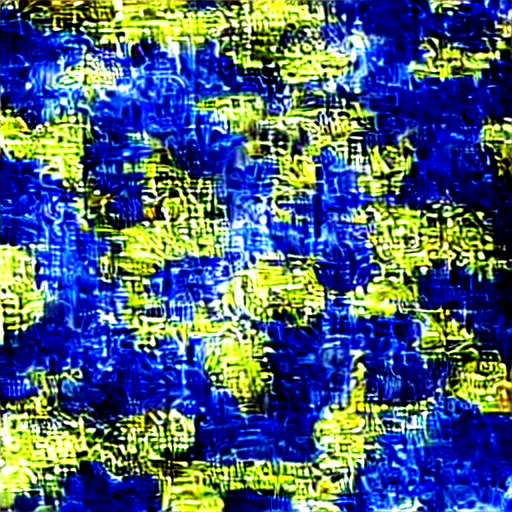

In [6]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = CLIPTokenizer("./data/vocab.json", merges_file="./data/merges.txt")
model_file = "./data/v1-5-pruned.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "Two students suffering from completing the generative model course project, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = False
cfg_scale = 8  # min: 1, max: 14

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=None,
    strength=0.9,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

**IMPORTANT REMARK** For the purpose of validating the model's training process, we have opted to utilize a representative dummy dataset. This dataset, while not the actual one, mirrors the format of the original CC3M dataset. It's worth noting that the CC3M dataset is considerably large, with a total size of approximately 430 GB. Given this substantial size, and considering our resource constraints, we have determined that it would not be feasible to complete the training process prior to the deadline for the first version, which is set for May 5. However, we have devised a plan to ensure that the training process is completed by the subsequent deadline for the second version, scheduled for May 31.

During the implementation of the model as described in the research paper, we encountered several areas of ambiguity that necessitated the formulation of certain assumptions. These assumptions, which guided our implementation, are detailed as follows:

1) The paper did not provide explicit information regarding whether the transformers employed for the image-to-text alignment task were part of a separate architecture or integrated within the proposed UNet middle blocks. Given this lack of clarity, our implementation treats the transformers as a distinct architecture.

2) The paper did not specify which blocks were to be modified to incorporate the dual stream deep fusion blocks. In our implementation, we have chosen to integrate these blocks into both the downsample and middle blocks of the original UNet, also known as Stable Diffusion. Notably, we did not apply these changes to the upsample layers, as they are not utilized in the image-to-text alignment task.

3) The term 'text query' was used in the paper without a clear definition. In our interpretation, we have chosen to represent the text query as the normalized average of the output from the text encoder.

4) The paper did not provide a clear methodology for the concatenation of the hidden latent image and the output of the fully connected layer. In our implementation, we expanded the output of the fully connected layer from a shape of (Batch Size, Channels) to (Batch Size, Channels, Height, Width), enabling its concatenation with the latent image, which also has a shape of (Batch Size, Channels, Height, Width).

5) The paper did not provide explicit instructions on how the fully connected layer projects the text query back into the text embedding space. We assumed that it generates an output with a shape of (Batch Size, Width * Height, 768). We then computed the normalized average of this output along dimension 1, resulting in an output of shape (Batch Size, 768). This output serves as the hidden text query that is input to the next layer.